## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.regularizers import l1, l2, l1_l2
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
def build_mlp_l1_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [11]:
results = {}
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    
    




Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 38us/step - loss: 5.9920 - acc: 0.2814 - val_loss: 5.7999 - val_acc: 0.3500
Epoch 2/50
50000/50000 [==============================] - 2s 34us/step - loss: 5.7111 - acc: 0.3696 - val_loss: 5.6468 - val_acc: 0.3747
Epoch 3/50
50000/50000 [==============================] - 2s 33us/step - loss: 5.5660 - acc: 0.3969 - val_loss: 5.5105 - val_acc: 0.4023
Epoch 4/50
50000/50000 [==============================] - 2s 34us/step - loss: 5.4444 - acc: 0.4158 - val_loss: 5.3932 - val_acc: 0.4230
Epoch 5/50
50000/50000 [==============================] - 2s 34us/step - loss: 5.3314 - acc: 0.4353 - val_loss: 5.2908 - val_acc: 0.4417
Epoch 6/50
50000/50000 [==============================] - 2s 33us/step - loss: 5.2284 - acc: 0.4471 - val_loss: 5.1886 - val_acc: 0.4530
Epoch 7/50
50000/50000 [==============================] - 2s 34us/step - loss: 5.1329 - acc: 0.4613 - val_loss: 5.1321 - val_acc

50000/50000 [==============================] - 2s 33us/step - loss: 1.8072 - acc: 0.3658 - val_loss: 1.7594 - val_acc: 0.3859
Epoch 3/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.7280 - acc: 0.3934 - val_loss: 1.6953 - val_acc: 0.4063
Epoch 4/50
50000/50000 [==============================] - 2s 35us/step - loss: 1.6701 - acc: 0.4156 - val_loss: 1.6446 - val_acc: 0.4270
Epoch 5/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.6217 - acc: 0.4333 - val_loss: 1.6082 - val_acc: 0.4303
Epoch 6/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.5835 - acc: 0.4458 - val_loss: 1.5717 - val_acc: 0.4492
Epoch 7/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.5481 - acc: 0.4578 - val_loss: 1.5498 - val_acc: 0.4539
Epoch 8/50
50000/50000 [==============================] - 2s 34us/step - loss: 1.5178 - acc: 0.4671 - val_loss: 1.5264 - val_acc: 0.4632
Epoch 9/50
50000/50000 [============================

50000/50000 [==============================] - 2s 33us/step - loss: 1.7276 - acc: 0.3947 - val_loss: 1.6992 - val_acc: 0.4045
Epoch 4/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.6703 - acc: 0.4141 - val_loss: 1.6484 - val_acc: 0.4220
Epoch 5/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.6224 - acc: 0.4298 - val_loss: 1.6067 - val_acc: 0.4365
Epoch 6/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.5827 - acc: 0.4454 - val_loss: 1.5856 - val_acc: 0.4414
Epoch 7/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.5507 - acc: 0.4552 - val_loss: 1.5713 - val_acc: 0.4443
Epoch 8/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.5193 - acc: 0.4664 - val_loss: 1.5216 - val_acc: 0.4613
Epoch 9/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.4928 - acc: 0.4785 - val_loss: 1.5293 - val_acc: 0.4620
Epoch 10/50
50000/50000 [===========================

TypeError: build_mlp_l1_l2() got an unexpected keyword argument 'l1_L2_ratio'

In [13]:
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1_l2(input_shape=x_train.shape[1:], l1_l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1_l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 39us/step - loss: 18.7746 - acc: 0.2777 - val_loss: 17.3293 - val_acc: 0.3523
Epoch 2/50
50000/50000 [==============================] - 2s 34us/step - loss: 16.1179 - acc: 0.3633 - val_loss: 14.9623 - val_acc: 0.3713
Epoch 3/50
50000/50000 [==============================] - 2s 34us/step - loss: 13.9378 - acc: 0.3824 - val_loss: 12.9571 - val_acc: 0.3891
Epoch 4/50
50000/50000 [==============================] - 2s 34us/step - loss: 12.0904 - acc: 0.3970 - val_loss: 11.2594 - val_acc: 0.4006
Epoch 5/50
50000/50000 [==============================] - 2s 33us/step - loss: 10.5202 - acc: 0.4090 - val_loss: 9.8112 - val_acc: 0.4109
Epoch 6/50
50000/50000 [==============================] - 2s 34us/step - loss: 9.1848 - acc: 0.4146 - val_loss: 8.5784 - val_acc: 0.4192
Epoch 7/50
50000/50000 [==============================] - 2s 34us/step - loss: 8.0476 - acc: 0.4213 - val_loss: 7.5330 

50000/50000 [==============================] - 2s 34us/step - loss: 12.9798 - acc: 0.3618 - val_loss: 12.0957 - val_acc: 0.3714
Epoch 3/50
50000/50000 [==============================] - 2s 35us/step - loss: 11.3126 - acc: 0.3824 - val_loss: 10.5677 - val_acc: 0.3897
Epoch 4/50
50000/50000 [==============================] - 2s 34us/step - loss: 9.9047 - acc: 0.3990 - val_loss: 9.2746 - val_acc: 0.4019
Epoch 5/50
50000/50000 [==============================] - 2s 34us/step - loss: 8.7084 - acc: 0.4081 - val_loss: 8.1703 - val_acc: 0.4103
Epoch 6/50
50000/50000 [==============================] - 2s 34us/step - loss: 7.6890 - acc: 0.4164 - val_loss: 7.2347 - val_acc: 0.4141
Epoch 7/50
50000/50000 [==============================] - 2s 34us/step - loss: 6.8196 - acc: 0.4227 - val_loss: 6.4302 - val_acc: 0.4216
Epoch 8/50
50000/50000 [==============================] - 2s 34us/step - loss: 6.0782 - acc: 0.4290 - val_loss: 5.7439 - val_acc: 0.4313
Epoch 9/50
50000/50000 [========================

50000/50000 [==============================] - 2s 34us/step - loss: 11.3441 - acc: 0.3847 - val_loss: 10.5910 - val_acc: 0.3887
Epoch 4/50
50000/50000 [==============================] - 2s 34us/step - loss: 9.9318 - acc: 0.3976 - val_loss: 9.3016 - val_acc: 0.3946
Epoch 5/50
50000/50000 [==============================] - 2s 34us/step - loss: 8.7314 - acc: 0.4079 - val_loss: 8.1884 - val_acc: 0.4143
Epoch 6/50
50000/50000 [==============================] - 2s 35us/step - loss: 7.7081 - acc: 0.4186 - val_loss: 7.2561 - val_acc: 0.4140
Epoch 7/50
50000/50000 [==============================] - 2s 34us/step - loss: 6.8359 - acc: 0.4226 - val_loss: 6.4422 - val_acc: 0.4220
Epoch 8/50
50000/50000 [==============================] - 2s 34us/step - loss: 6.0909 - acc: 0.4300 - val_loss: 5.7522 - val_acc: 0.4319
Epoch 9/50
50000/50000 [==============================] - 2s 34us/step - loss: 5.4554 - acc: 0.4355 - val_loss: 5.1801 - val_acc: 0.4255
Epoch 10/50
50000/50000 [=========================

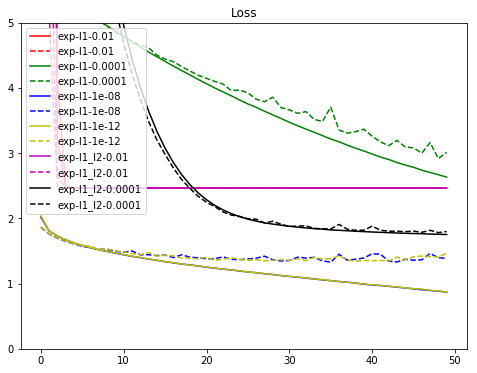

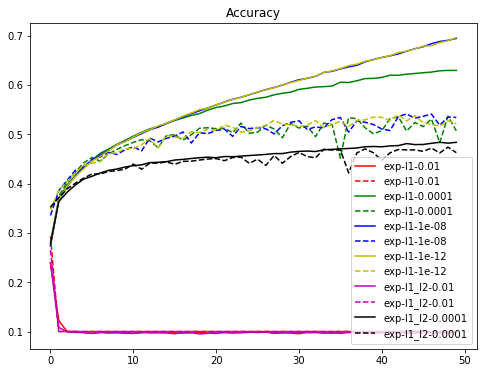

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    if i >5:
        break
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    if i >5:
        break
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()